In [67]:

import io, os, glob
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [68]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [69]:

import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [70]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [71]:

csv_files = [f for f in os.listdir('/content') if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in Colab left Files panel. Upload it first!")

In [72]:
file_name = csv_files[0]
csv_path = f"/content/{file_name}"
print("✅ Found dataset:", csv_path)


✅ Found dataset: /content/india-news-headlines.csv


In [73]:

df = pd.read_csv(
    csv_path,
    usecols=['headline_text'],
    engine='python',
    on_bad_lines='skip'
)
print("✅ Loaded shape:", df.shape)

✅ Loaded shape: (3876557, 1)


In [74]:

df.dropna(subset=['headline_text'], inplace=True)
df = df[df['headline_text'].str.strip() != ""].reset_index(drop=True)
print("✅ After cleaning shape:", df.shape)

✅ After cleaning shape: (3876557, 1)


In [75]:

sample_n = 20000
if len(df) > sample_n:
    df = df.sample(sample_n, random_state=42).reset_index(drop=True)
    print(f"✅ Sampled {sample_n} rows for fast training")
else:
    print("✅ Using full dataset")

✅ Sampled 20000 rows for fast training


In [76]:

def clean_text(x):
    x = str(x).lower()
    x = re.sub(r"[^a-zA-Z0-9\s']", " ", x)
    x = re.sub(r"\s+", " ", x)
    return x.strip()

df['clean_text'] = df['headline_text'].apply(clean_text)


In [77]:

sid = SentimentIntensityAnalyzer()
def get_label(text):
    score = sid.polarity_scores(text)['compound']
    return 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral'

df['label'] = df['clean_text'].apply(get_label)
print("\n✅ Label Distribution:")
print(df['label'].value_counts())


✅ Label Distribution:
label
neutral     9642
negative    6037
positive    4321
Name: count, dtype: int64


In [78]:

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [79]:

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
y = df['label_encoded']

In [80]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [81]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []

In [82]:

for name, model in models.items():
    print(f"\n▶ Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    results.append((name, acc, f1))


▶ Training Logistic Regression ...
Logistic Regression → Accuracy: 0.8010, F1: 0.7726
              precision    recall  f1-score   support

    negative       0.90      0.70      0.79      1207
     neutral       0.75      0.97      0.84      1929
    positive       0.89      0.56      0.69       864

    accuracy                           0.80      4000
   macro avg       0.84      0.74      0.77      4000
weighted avg       0.82      0.80      0.79      4000


▶ Training Naive Bayes ...
Naive Bayes → Accuracy: 0.7550, F1: 0.7160
              precision    recall  f1-score   support

    negative       0.83      0.67      0.74      1207
     neutral       0.71      0.94      0.81      1929
    positive       0.86      0.46      0.60       864

    accuracy                           0.76      4000
   macro avg       0.80      0.69      0.72      4000
weighted avg       0.78      0.76      0.74      4000


▶ Training SVM ...
SVM → Accuracy: 0.8320, F1: 0.8140
              precision  

In [83]:

res_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print("\n=== ✅ MODEL COMPARISON ===")
print(res_df)



=== ✅ MODEL COMPARISON ===
                 Model  Accuracy  F1 Score
0  Logistic Regression     0.801  0.772628
1          Naive Bayes     0.755  0.715967
2                  SVM     0.832  0.814007
3        Random Forest     0.850  0.830704


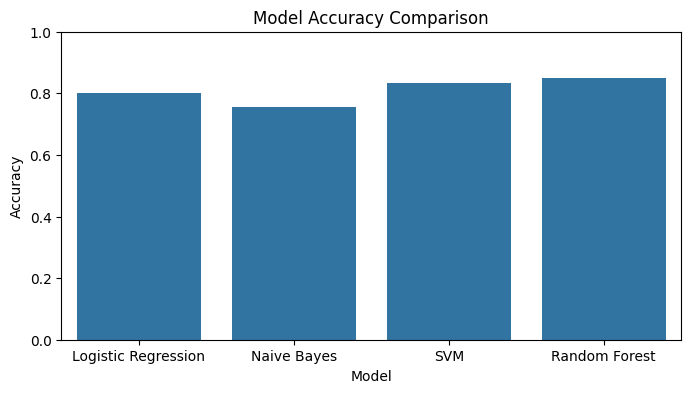

In [84]:

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=res_df)
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.show()


 MODEL PERFORMANCE TABLE


,Model,Accuracy,F1 Score
3,Random Forest,0.850000,0.830704
2,SVM,0.832000,0.814007
0,Logistic Regression,0.801000,0.772628
1,Naive Bayes,0.755000,0.715967


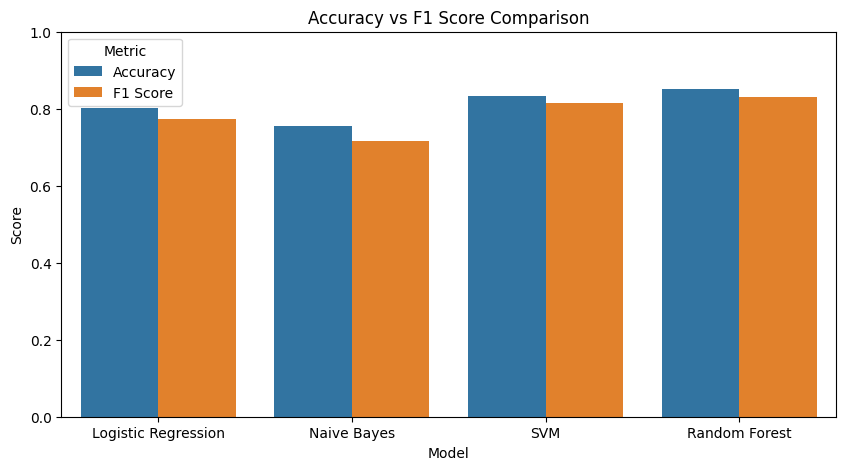

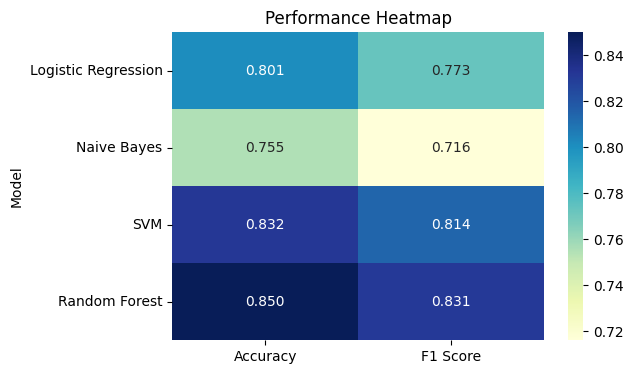

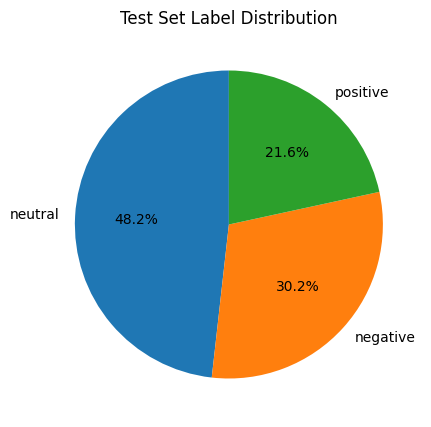


Confusion Matrix: Logistic Regression


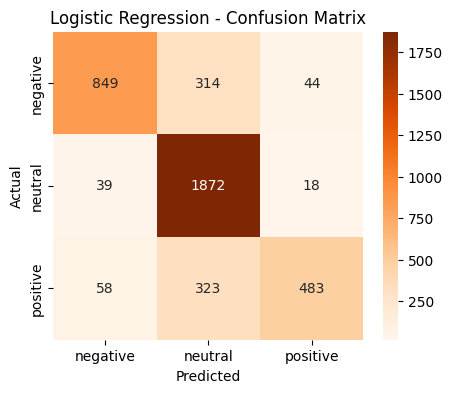


Confusion Matrix: Naive Bayes


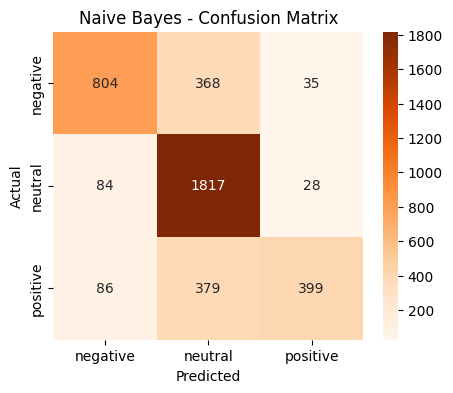


Confusion Matrix: SVM


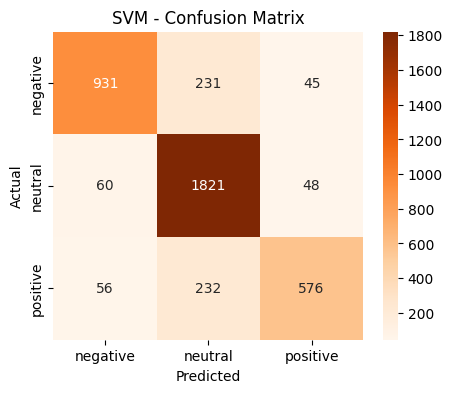


Confusion Matrix: Random Forest


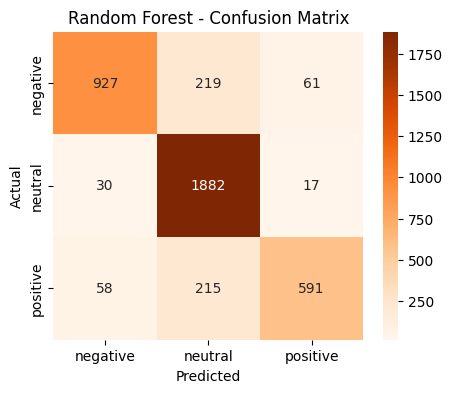

In [87]:





res_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
res_df_sorted = res_df.sort_values(by="Accuracy", ascending=False)


print("\n MODEL PERFORMANCE TABLE")
display(res_df_sorted.style.background_gradient(cmap='Greens'))


res_melted = res_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10,5))
sns.barplot(data=res_melted, x="Model", y="Score", hue="Metric")
plt.title("Accuracy vs F1 Score Comparison")
plt.ylim(0,1)
plt.show()


plt.figure(figsize=(6,4))
sns.heatmap(res_df.set_index('Model'), annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Performance Heatmap")
plt.show()


test_labels = le.inverse_transform(y_test)
label_counts = pd.Series(test_labels).value_counts()

plt.figure(figsize=(5,5))
label_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Test Set Label Distribution")
plt.ylabel("")
plt.show()


for name, model in models.items():
    print(f"\nConfusion Matrix: {name}")
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
